In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import time
import imageio

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from IPython.display import clear_output

from lib.CAModel import CAModel
from lib.utils_vis import SamplePoolv2, to_alpha, to_rgb, get_living_mask, make_seed, make_circle_masks, make_targets

In [2]:
def load_emoji(index, path="data/emoji.png"):
    im = imageio.imread(path)
    emoji = np.array(im[:, index*40:(index+1)*40].astype(np.float32))
    emoji /= 255.0
    return emoji

def load_new_im(path="data/kirby.png"):
    im = imageio.imread(path)
    im = np.array(im.astype(np.float32))
    im /= 255.0
    return im

def visualize_batch(x0, x, labels):
    vis0 = to_rgb(x0)
    vis1 = to_rgb(x)
    vis2 = to_rgb(labels)

    print('batch (before/after):')
    plt.figure(figsize=[15,4])
    for i in range(x0.shape[0]):
        plt.subplot(3,x0.shape[0],i+1)
        plt.imshow(vis0[i])
        plt.axis('off')
    for i in range(x0.shape[0]):
        plt.subplot(3,x0.shape[0],i+1+x0.shape[0])
        plt.imshow(vis1[i])
        plt.axis('off')
    for i in range(x0.shape[0]):
        plt.subplot(3,x0.shape[0],i+1+2 * x0.shape[0])
        plt.imshow(vis2[i])
        plt.axis('off')


    plt.show()

def plot_loss(loss_log):
    plt.figure(figsize=(10, 4))
    plt.title('Loss history (log10)')
    plt.plot(np.log10(loss_log), '.', alpha=0.1)
    plt.show()

In [3]:
device = torch.device("cuda:0")
model_path = "models/test2.pth"

CHANNEL_N = 16        # Number of CA state channels
TARGET_PADDING = 16   # Number of pixels used to pad the target image border
TARGET_SIZE = 60

lr = 2e-3
lr_gamma = 0.9999
betas = (0.5, 0.5)
n_epoch = 80000

BATCH_SIZE = 16
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

TARGET_EMOJI = 1 #@param "🦎"

EXPERIMENT_TYPE = "Regenerating"
EXPERIMENT_MAP = {"Growing":0, "Persistent":1, "Regenerating":2}
EXPERIMENT_N = EXPERIMENT_MAP[EXPERIMENT_TYPE]

USE_PATTERN_POOL = [0, 1, 1][EXPERIMENT_N]
DAMAGE_N = [0, 0, 3][EXPERIMENT_N]  # Number of patterns to damage in a batch

(40, 40, 4)


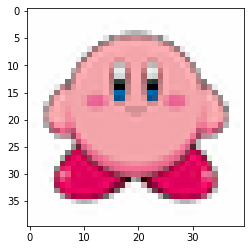

(60, 60, 4)


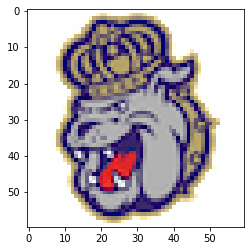

In [4]:
#target_img = load_emoji(TARGET_EMOJI)
target_imgs = (load_new_im(), load_new_im("data/jmu_jdog.png"))
for target in target_imgs:
    print(target.shape)
    plt.figure(figsize=(4,4))
    plt.imshow(to_rgb(target))
    plt.show()

[[1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]]
(92, 92, 16)
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]


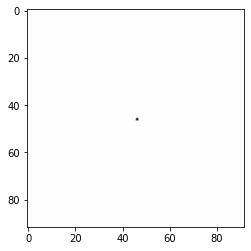

(92, 92, 16)
[0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]


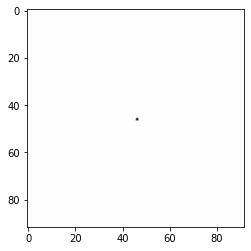

In [5]:
def pad(target_img):
    p = TARGET_PADDING
    pad_target = np.pad(target_img, [(p, p), (p, p), (0, 0)])
    return pad_target
target_imgs_padded = [pad(target) for target in target_imgs]
padded_targets = torch.from_numpy(make_targets(target_imgs_padded, n=2)).to(device)

#seed_values = [np.mean(target, axis=(0,1), where=target>0) for target in target_imgs]
seed_values = np.zeros((2, CHANNEL_N - 3))
seed_values[:, 0] = 1
seed_values[1, :int((CHANNEL_N - 3)/2)] = 1
seed_values[0, int((CHANNEL_N - 3)/2)+1:] = 1
seeds = [make_seed(padded_targets[0].shape[:2], CHANNEL_N, value=value) for value in seed_values]
print(seed_values)
for seed in seeds:
    print(seed.shape)
    print(seed[seed.shape[0]//2, seed.shape[1]//2])
    plt.figure(figsize=(4,4))
    plt.imshow(to_rgb(seed))
    plt.show()

In [6]:
pool = SamplePoolv2(POOL_SIZE, CHANNEL_N, targets=[0, 1], seeds=seeds, device=device)
batch_x, batch_y = pool.sample(BATCH_SIZE)
print(batch_x.shape)
print(batch_y.shape)
w,h = batch_x.shape[1:3]
seeds = torch.from_numpy(np.array(seeds, dtype=np.float32))
print(seeds.shape)

torch.Size([16, 92, 92, 16])
(16,)
torch.Size([2, 92, 92, 16])


In [7]:
ca = CAModel(CHANNEL_N, CELL_FIRE_RATE, device).to(device)
ca.load_state_dict(torch.load("models/jmu_dog_v1.pth"))

optimizer = optim.Adam(ca.parameters(), lr=lr, betas=betas)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, lr_gamma)

80000 loss = 0.007289178669452667
batch (before/after):


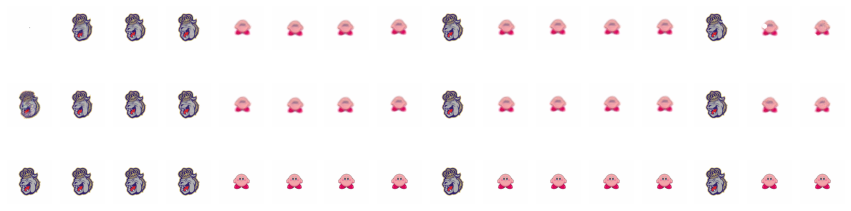

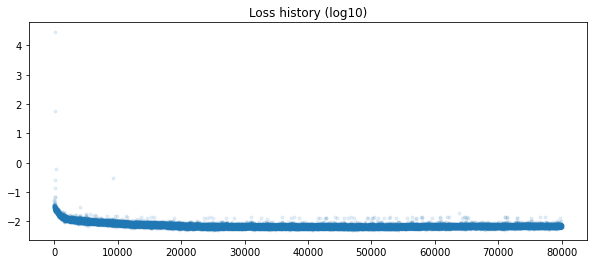

In [8]:
loss_log = []

def train(x, target, steps, optimizer, scheduler):
    x = ca(x, steps=steps)
    loss = F.mse_loss(x[:, :, :, :4], target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    return x, loss

def loss_f(x, target):
    return torch.mean(torch.pow(x[..., :4]-target, 2), [-2,-3,-1])

for i in range(n_epoch+1):
    batch_x, batch_y = pool.sample(BATCH_SIZE)
        
    x0 = batch_x.detach().cpu().numpy()
    y0 = padded_targets[batch_y]
    loss_rank = loss_f(batch_x, y0).detach().cpu().numpy().argsort()[::-1]
    
    x0[loss_rank[0]] = seeds[batch_y[loss_rank[0]]]
    if DAMAGE_N:
        damage = 1.0-make_circle_masks(DAMAGE_N, h, w)[..., None]
        x0[loss_rank[loss_rank.shape[0] - DAMAGE_N:].copy()] *= damage
        
    x0 = torch.from_numpy(x0.astype(np.float32)).to(device)

    x, loss = train(x0, y0, np.random.randint(64,96), optimizer, scheduler)
    
    x = x.detach()
    pool.commit(x)
    
    step_i = len(loss_log)
    loss_log.append(loss.item())

    if step_i%100 == 0:
        clear_output()
        print(step_i, "loss =", loss.item())
        visualize_batch(x0.detach().cpu().numpy()[loss_rank], x.cpu().numpy()[loss_rank], y0.detach().cpu().numpy()[loss_rank])
        plot_loss(loss_log)
        torch.save(ca.state_dict(), model_path)


tensor([[[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         ...,

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, n

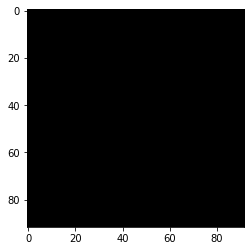

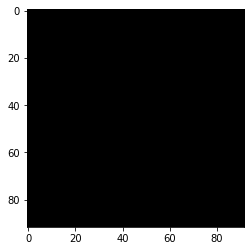

In [19]:
dog = ca(seeds[np.newaxis, 1].to(device), steps=1)
kirby = ca(seeds[np.newaxis, 0].to(device), steps=1)

plt.figure(figsize=(4,4))
plt.imshow(to_rgb(dog.detach().cpu().numpy()[0]))
plt.show()
plt.figure(figsize=(4,4))
plt.imshow(to_rgb(kirby.detach().cpu().numpy()[0]))
plt.show()